<a href="https://colab.research.google.com/github/EkaterinaEvdakova/Portfolio/blob/master/GRANT2023_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cравнительный анализ влияния длины ЭКГ фрагмента на качество распознавания опасных аритмий


**Задача 1.** Классификация на два класса:
I – группа опасных нарушений (классы 1, 2, 3);
II – группа неопасных нарушений (классы 4, 5, 6).

**Задача 2.** Классификация группы опасных аритмий (классы 1, 2, 3) на два класса:
I – группа крайне опасных нарушений (классы 1, 2), требующих применения дефибрилляции;
II – класс угрожающих аритмий (класс 3).

***Данные:  ***

 Случай I :
Использовать нормированное спектральные описания ЭКГ фрагментов.
- Для 2 с фрагментов: «2_15» - сглаженный спектр с шагом 1 Гц (область 0-15 Гц, число признаков N=15);
- Для 4 с фрагментов:
«spec_4_15» - сглаженный спектр с шагом 1 Гц (0-15 Гц, N=15).

***Методы классификации: ***
- метод ближайших соседей (kNN) с оценкой средневзвешенного расстояния;
- линейный дискриминантный анализ (LDA);
- метод опорных векторов (SVM) – с разными ядрами (линейное, квадратичное, кубическое ядро).


In [ ]:
frag2 = '/content/drive/MyDrive/GRANT2023_datasets/new1006/frag/frag_'
spec2 = '/content/drive/MyDrive/GRANT2023_datasets/spec/2_15/spec_2_15_'
spec4= '/content/drive/MyDrive/GRANT2023_datasets/new1006/spec/spec_2_30_'

### Установка библиотек

In [ ]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn. discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold,train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import (recall_score,
                             precision_score,
                             balanced_accuracy_score,
                             roc_auc_score,
                             confusion_matrix,
                             roc_curve,
                             make_scorer,
                             f1_score,
                             accuracy_score)
import warnings
warnings.filterwarnings("ignore")

### Функции

In [ ]:
#Чтение данных
def read_dataset(path,test_size_):
    if test_size_>0:

      data = []
      data_train = []
      data_test = []
      for i in range(6):
         path_way = path + str(i+1) + '_all.txt'
         data.append(pd.read_csv(path_way,sep=' ', header = None))
         data[i] = prepare_data(data[i], i)
         data_train_, data_test_ = train_test_split(data[i],test_size=test_size_, random_state=12345)
         data_train.append(data_train_)
         data_test.append(data_test_)
         if i>0:
           data_train_all = pd.concat([data_train_all, data_train[i]],ignore_index=True)
           data_test_all = pd.concat([data_test_all, data_test[i]],ignore_index=True)
         else:
           data_train_all = data_train[i].copy()
           data_test_all = data_test[i].copy()
    else:

        data = []
        for i in range(6):
          path_way = path + str(i+1) + '_all.txt'
          data.append(pd.read_csv(path_way,sep=' ', header = None))
          data[i] = prepare_data(data[i], i)
          if i>0:
            data_train_all = pd.concat([data_train_all, data[i]],ignore_index=True)
          else:
            data_train_all = data[i].copy()
            data_test_all = []

    return data_train_all, data_test_all


def prepare_data(data, i):
    data = data.rename(columns = {0 : 'name_frag'})
    data['num_class'] = i+1
    return data

def data_info(data):
    df_info = pd.DataFrame( columns = [
                                        'num_class', 'len_class', 'sum of null', 'mean', 'std', 'median', 'max', 'min'
                                       ])
    for i in range(6):
      data_info_class = []
      data_class = data[data['num_class'] == (i+1)]
      data_class = data_class.drop(columns = ['name_frag', 'num_class'])
      data_info_class.append(i+1)
      data_info_class.append(len(data_class))
      data_info_class.append(np.sum(data_class.isnull().sum()))
      data_info_class.append(np.mean(data_class.mean()))
      data_info_class.append(np.std(data_class.std()))
      data_info_class.append(np.median(data_class.median()))
      data_info_class.append(np.max(data_class.max()))
      data_info_class.append(np.min(data_class.min()))
      df_info.loc[len(df_info)]  = data_info_class
    return df_info




In [ ]:
# Вывод первых фрагментов сигнала каждого класса
def present_frag(data, title, Nmax):
  Nmax = round(Nmax)
  fig, ax = plt.subplots(2, 3, figsize=(30,10))
  t = np.arange(0, len(data.loc[0][1:(-1)])) * Nmax/len(data.loc[0][1:(-1)])
  fig.suptitle(title)
  k = 0
  j = 0

  for i in range(6):
    data_class = data[data['num_class'] == (i+1)].iloc[5]
    data_class_ = data[data['num_class'] == (i+1)].iloc[10]
    data_class__ = data[data['num_class'] == (i+1)].iloc[40]
    ax[k,j ].plot(t, data_class[1:-1],t, data_class_[1:-1],t, data_class__[1:-1])
    ax[k,j ].set_title(data_class['name_frag'] +' class:'+ str(data_class['num_class']))
    ax[k,j ].set_xlim([0, Nmax])
    ax[k,j ].set_xlabel('time, s'),
    ax[k,j ].set_ylabel('fragment, uV')
    j = k+j
    if k == 1 :
      k=0
    else:
      k+=1


In [ ]:
#Задача 1
def data_prepare(data):
  data_shuffle = shuffle(data, random_state=1234)
  features = data_shuffle.drop(columns = ['name_frag', 'num_class'])
  features_power = features[1]
  features = features.drop(columns = [1])
  target = data_shuffle['num_class']
  target[(target ==1) | (target ==2) | (target ==3)] = 1
  target[(target ==4) | (target ==5) | (target ==6)] = 0
  features_norm = np.array(features.copy())
  for i in range(len(features_power)):
     features_norm[i] = features_norm[i]/features_power.iloc[i]
  features = features_norm.copy()
  return features, target

In [ ]:
def study_model(model, param, X, Y):
  cv1 = KFold(10, shuffle=True, random_state=1234)
  grid = GridSearchCV(model, param, cv = cv1,scoring='f1')
  grid.fit (X, Y)
  f1_score= grid.best_score_
  accuracy =  np.mean(cross_val_score(grid.best_estimator_, X,Y, scoring='accuracy', cv=cv1))
  balanced_acc = make_scorer(balanced_accuracy_score)
  f1_score_mean = np.mean(cross_val_score(grid.best_estimator_, X,Y,  scoring='f1', cv=cv1))
  recall = np.mean(cross_val_score(grid.best_estimator_, X,Y, scoring='recall', cv=cv1))
  precision = np.mean(cross_val_score(grid.best_estimator_, X,Y, scoring='precision', cv=cv1))
  balanced_accuracy = np.mean(cross_val_score(grid.best_estimator_, X,Y, scoring=balanced_acc, cv=cv1))
  roc_auc_score = np.mean(cross_val_score(grid.best_estimator_, X,Y, scoring='roc_auc', cv=cv1))
  best_param =  grid.best_params_
  score_all = [grid.best_estimator_,best_param,  f1_score, f1_score_mean, accuracy, recall, precision, balanced_accuracy, roc_auc_score]
  return grid, score_all

In [ ]:
def test_model(model, X, Y):
  pred = model.predict(X)
  accuracy = accuracy_score(Y, pred)
  balanced_acc =balanced_accuracy_score(Y, pred)
  f1 = f1_score(Y, pred)
  recall = recall_score(Y, pred)
  precision = precision_score(Y, pred)
  matrix = confusion_matrix(Y, pred)
  score_all = [model, f1, accuracy, recall, precision, balanced_acc,matrix]
  probabilities = model.predict_proba(X)
  return score_all, probabilities

In [ ]:
def test_result(models, X, Y):

  columns_score = ['model', 'f1', 'accuracy', 'recall', 'precision', 'balanced_acc']
  score_df_test = pd.DataFrame( columns = columns_score)
  i = 0
  k=0
  for model in models:
    i+=1
    score_test, probabilities = test_model(model,  X, Y)
    score_df_test = pd.concat([score_df_test, pd.DataFrame(
        [score_test[:-1]], columns = columns_score)],ignore_index=True)
    plt.subplot(3,2, i)
    df_cm = pd.DataFrame(score_test[-1].astype(int), range(2), range(2))
    sn.set(font_scale=1) # for label size
    sn.heatmap(df_cm, annot=True, fmt=".1f") # font size
    plt.xlabel('pred')
    plt.ylabel('y')
    plt.show()
    i+=1
    plt.subplot(3,2, i)
    fpr, tpr, thresholds = roc_curve(Y, probabilities[:,1])
    k+=1
    plt.plot(fpr,tpr, label="ROC Curve",color="blue")

    plt.xlabel("False Positve Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


  return score_df_test


### Данные : 2 секунды

#### Фрагмент

In [ ]:
#Загружаем данные, 2-х секундные фрагменты сигналов
path =frag2
data_2s, data_2s_test = read_dataset(path, 0.2)

In [ ]:
# выгрузим первые 5 строк общего датасета
data_2s.head(5)

,name_frag,1,2,3,4,5,6,7,8,9,...,1433,1434,1435,1436,1437,1438,1439,1440,1441,num_class
0,430_C_VFL_455s,9.797111,8.691781,9.143570,10.104034,11.411877,10.734374,7.354709,1.871482,-6.082105,...,12.588867,14.465413,17.244310,21.393569,26.308832,30.333634,33.892347,35.859528,36.683774,1
1,614_C_VF_1081.5s,528.139968,522.312685,518.597872,513.375620,502.961393,485.525190,462.339725,432.291118,394.875336,...,-234.645297,-194.657388,-148.269941,-94.886905,-37.263557,22.119465,78.458263,127.968217,168.777002,1
2,422_C_VF_1225s,-89.496080,-77.663621,-62.421931,-48.363551,-39.433370,-33.245173,-26.240362,-17.452391,-6.356927,...,-26.467261,-41.032412,-52.984327,-63.275363,-73.028178,-82.939225,-92.273158,-100.458274,-106.632726,1
3,427_C_VFL_544.5s,10.955247,-0.068139,-11.820366,-23.477290,-33.570777,-42.537416,-49.435904,-54.931331,-60.689741,...,8.841701,14.224649,18.047395,19.302111,21.660459,25.334370,31.393552,38.329933,45.760667,1
4,614_C_VF_1185.6s,-11.924710,-46.504415,-85.359291,-124.133175,-158.487981,-188.268492,-215.152458,-240.988754,-278.617096,...,478.917638,467.326149,445.790265,415.119118,383.159227,351.795698,324.062266,296.307882,266.765339,1


In [ ]:
# Общая информация по классам
#num_class  - номер класса
#len_class	- количество объектов в классе
#sum of null	- количество пропусков в данных
#mean	- среднее значение в классе
#std	- отклонение
#median	- медиана
#max	- максимальное значение
#min - минимальное значение

df_info_2s = data_info(data_2s)
df_info_2s

,num_class,len_class,sum of null,mean,std,median,max,min
0,1.0,294.0,0.0,-0.615481,10.631084,-0.024039,1102.102453,-1142.924273
1,2.0,56.0,0.0,-7.527680,29.233747,0.257343,909.104912,-1171.180308
2,3.0,142.0,0.0,2.834346,33.077126,0.698294,1882.610734,-2258.565420
3,4.0,112.0,0.0,0.414922,23.714482,1.286494,1660.709017,-901.183851
4,5.0,87.0,0.0,-4.559965,36.320510,0.309636,1017.339146,-1717.068742
5,6.0,166.0,0.0,2.619724,12.109488,0.541148,746.004180,-431.412596


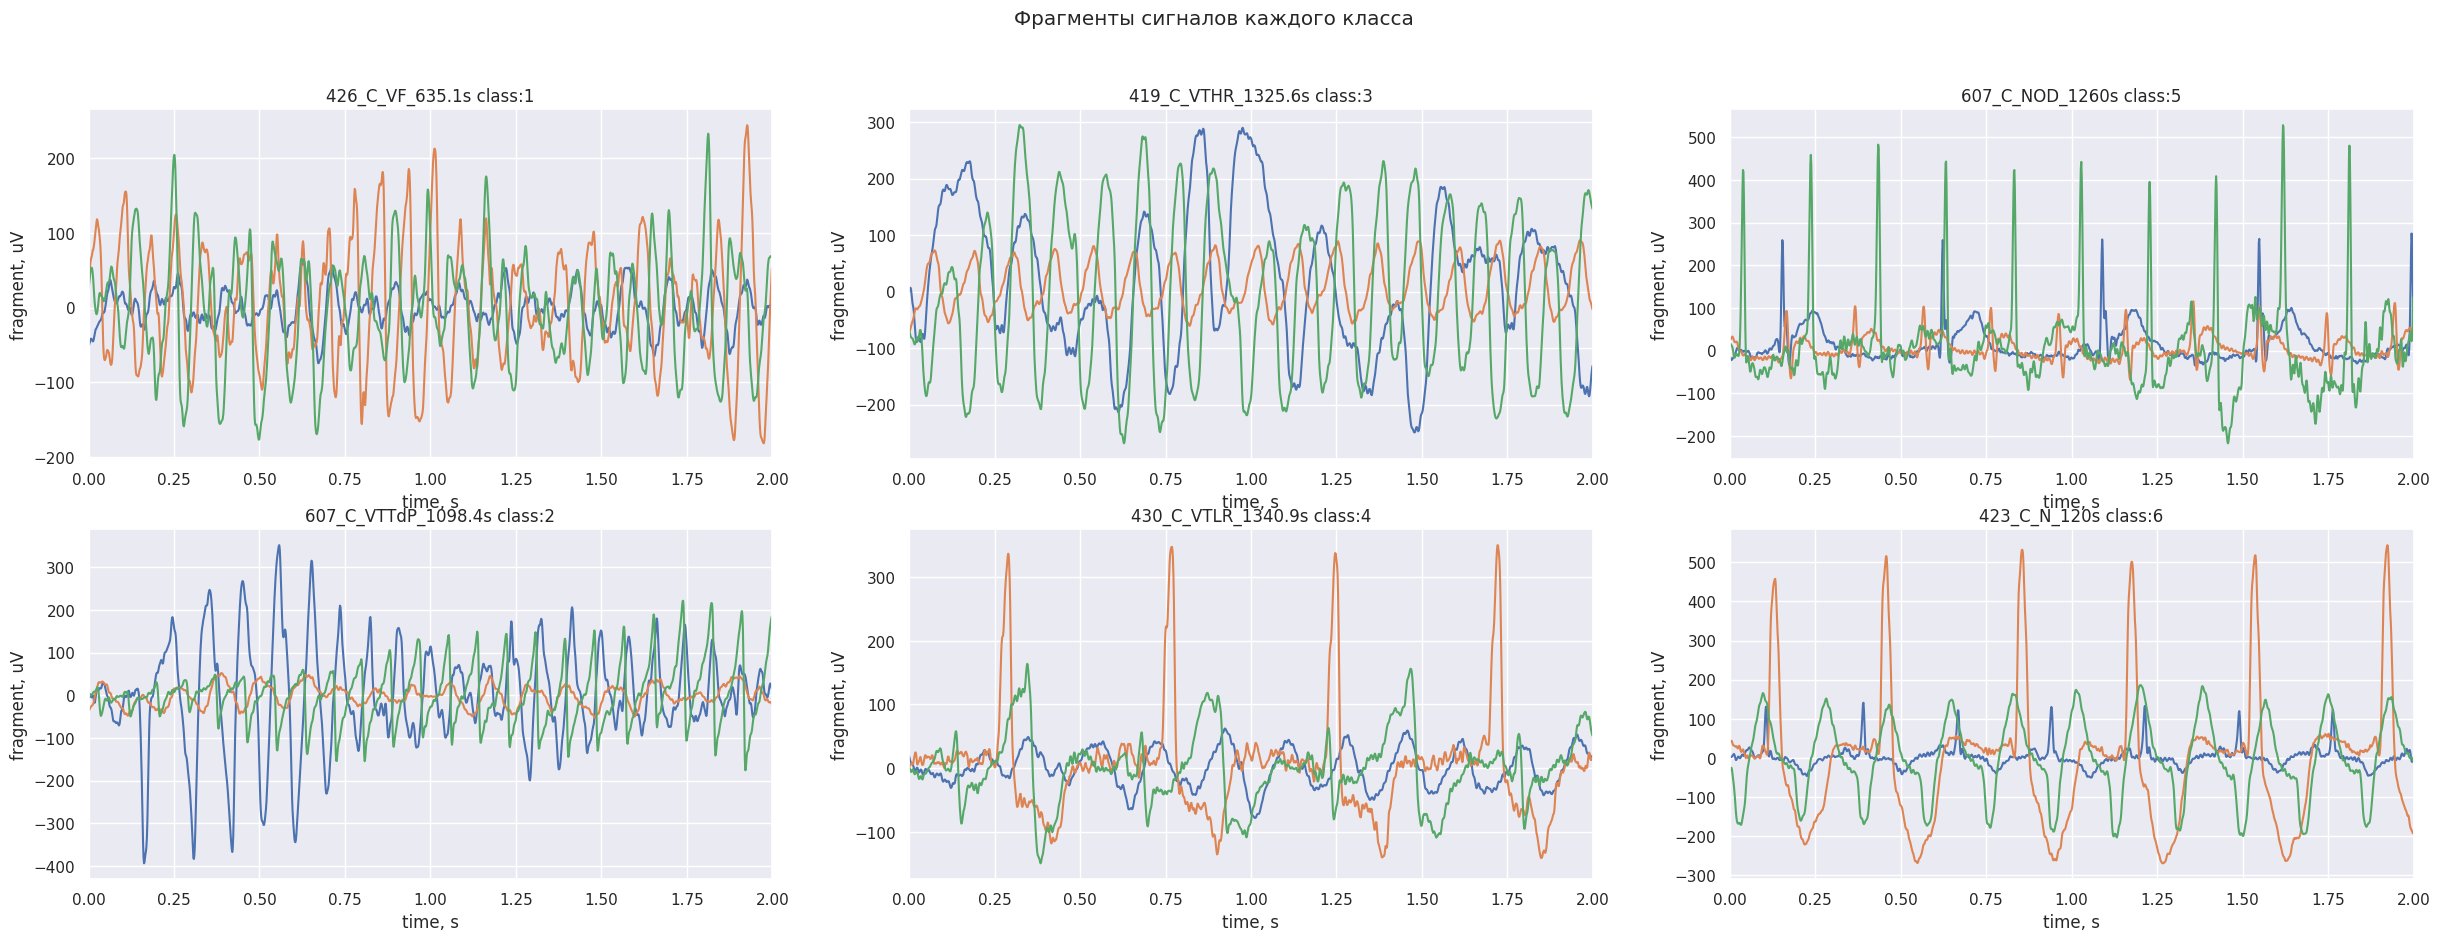

In [ ]:
present_frag(data_2s, 'Фрагменты сигналов каждого класса', 2)

#### Спектр

In [ ]:
path_spectrum_2_15 = spec2
data_2_15_train, data_2_15_test = read_dataset(path_spectrum_2_15, 0.2)
data_2_15_test.tail(5)

,name_frag,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,num_class
201,425_C_N_410s,645.84,206.3300,103.14,65.4910,19.9330,15.7860,7.7830,21.4820,23.777,21.305,30.8930,22.873,12.8160,12.386,12.8600,9.7568,6
202,421_C_N_106s,6284.10,16.5180,228.80,1006.7000,3.3007,642.5800,68.3970,139.4000,467.950,23.819,595.5500,80.824,158.6200,323.540,18.7490,423.4200,6
203,425_C_N_1324.6s,243.52,9.8852,19.68,30.4510,9.8891,3.8835,2.0775,8.0331,21.905,17.582,27.6530,17.375,11.0290,7.960,9.8284,8.3150,6
204,609_C_N_910s,7280.10,731.5100,545.45,544.6700,399.6000,664.2900,404.6700,311.7700,375.670,302.590,284.4300,273.400,291.1600,341.260,222.4800,197.3100,6
205,423_C_N_22s,448.17,9.0650,213.94,2.0928,12.3530,4.2319,8.1110,40.0360,16.070,20.313,2.5755,26.041,2.0767,10.052,2.9812,4.5728,6


In [ ]:
# Общая информация по классам
#num_class  - номер класса
#len_class	- количество объектов в классе
#sum of null	- количество пропусков в данных
#mean	- среднее значение в классе
#std	- отклонение
#median	- медиана
#max	- максимальное значение
#min - минимальное значение
df_info_2_15 = data_info(data_2_15_train)
df_info_2_15

,num_class,len_class,sum of null,mean,std,median,max,min
0,1.0,269.0,0.0,994.871120,7533.238959,20.90750,375290.0,0.010002
1,2.0,57.0,0.0,3771.209989,20746.525019,54.87800,550690.0,0.099671
2,3.0,135.0,0.0,6768.542763,36282.758212,105.01400,803830.0,0.009756
3,4.0,105.0,0.0,2232.229595,4002.073238,317.30500,87801.0,0.010669
4,5.0,84.0,0.0,1622.704631,3741.361537,284.98250,79134.0,0.094976
5,6.0,160.0,0.0,769.781235,2106.517753,46.95775,84925.0,0.062831


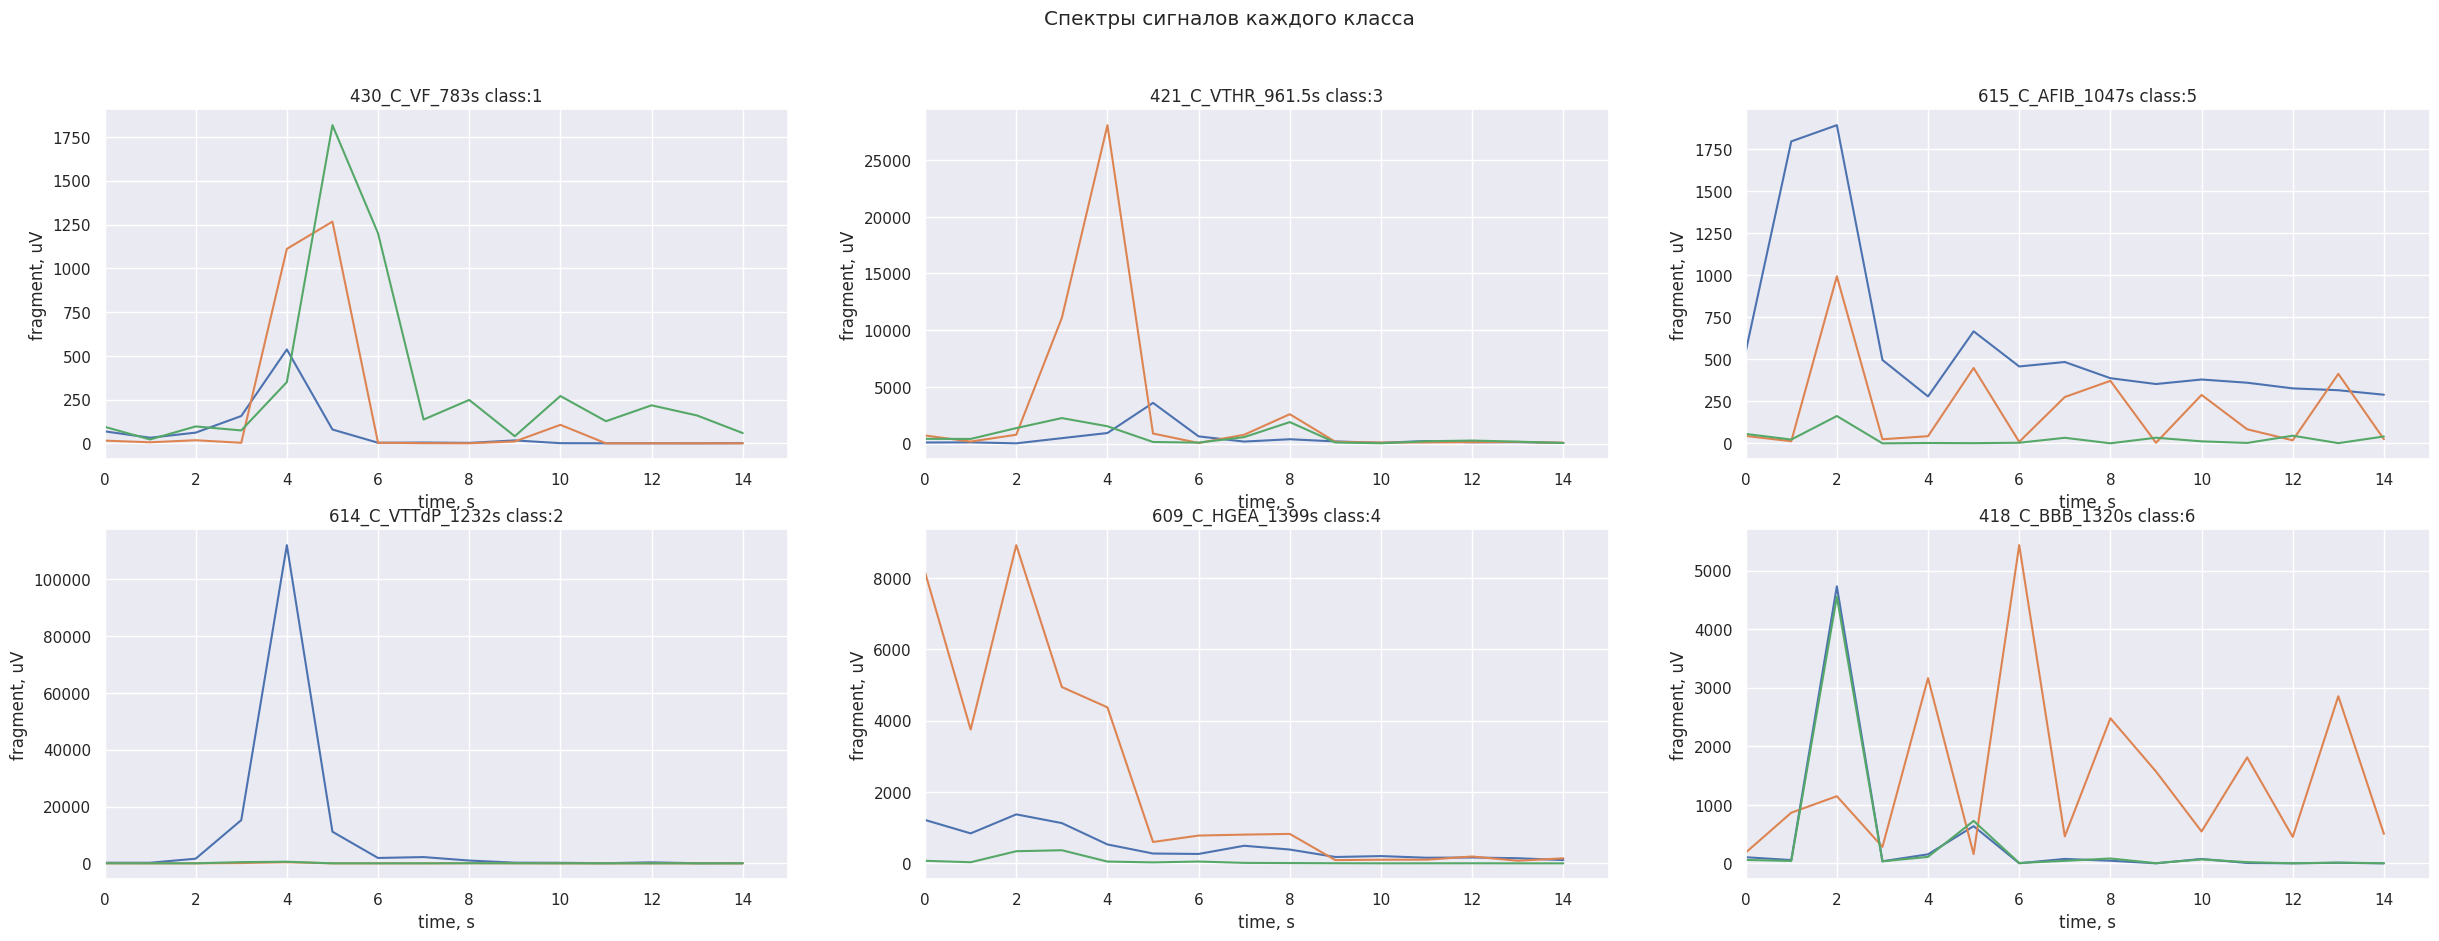

In [ ]:
present_frag(data_2_15_train.drop(columns = 1),'Спектры сигналов каждого класса', 15)

### Данные 4 секунды

#### Спектр

**Сглаженный спектр с шагом 1.0 Гц (область 0-15 Гц, число признаков N=15)**

In [ ]:
path_spectrum_4_15 = spec4
data_4_15_train, data_4_15_test = read_dataset(path_spectrum_4_15, 0.2)
data_4_15_train.tail(5)

,name_frag,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,num_class
852,419_C_BBB_37.3s,4631.10,30.8200,18.3060,2.5619,10.4670,2316.000000,1235.10000,2.94380,1.13970,...,2.6075,0.31629,0.67645,1.904,21.7770,1.16070,0.21214,0.5704,0.84625,6
853,423_C_N_0.1s,487.57,10.8060,3.9106,12.6000,199.2600,0.282620,0.23538,14.65000,7.73140,...,23.3060,0.52535,0.54229,11.580,5.2528,0.11225,1.32340,6.3248,0.29018,6
854,422_C_Ne_309.5s,6807.90,22.6820,7.2249,51.9700,36.8610,799.180000,128.46000,16.90800,3.49290,...,63.2130,27.10300,113.42000,212.780,75.2780,31.51800,86.32500,362.1800,160.33000,6
855,420_C_N_44.5s,564.15,11.3130,3.1645,36.3040,9.0122,0.051599,34.36400,12.78900,0.54045,...,13.2770,7.91360,11.21400,20.547,9.1573,11.68700,19.04700,8.7301,11.20100,6
856,422_C_N_816s,7702.40,4.9437,12.6330,4.4868,7.7642,1477.800000,81.31700,0.67127,6.17750,...,6.9647,9.71040,225.92000,293.340,6.0489,7.04690,11.32400,403.3800,200.06000,6


In [ ]:
# Общая информация по классам
#num_class  - номер класса
#len_class	- количество объектов в классе
#sum of null	- количество пропусков в данных
#mean	- среднее значение в классе
#std	- отклонение
#median	- медиана
#max	- максимальное значение
#min - минимальное значение
df_info_4_15 = data_info(data_4_15_train)
df_info_4_15

,num_class,len_class,sum of null,mean,std,median,max,min
0,1.0,294.0,0.0,1324.226550,6820.717770,30.0705,238270.0,0.010374
1,2.0,56.0,0.0,2155.224248,8434.172535,28.2940,168130.0,0.002942
2,3.0,142.0,0.0,1223.047083,12377.154291,13.5565,629090.0,0.010668
3,4.0,112.0,0.0,628.820279,2422.350648,31.9425,73803.0,0.041969
4,5.0,87.0,0.0,648.168309,2378.322071,39.8530,83520.0,0.004144
5,6.0,166.0,0.0,316.236979,952.644711,12.8175,22301.0,0.009879


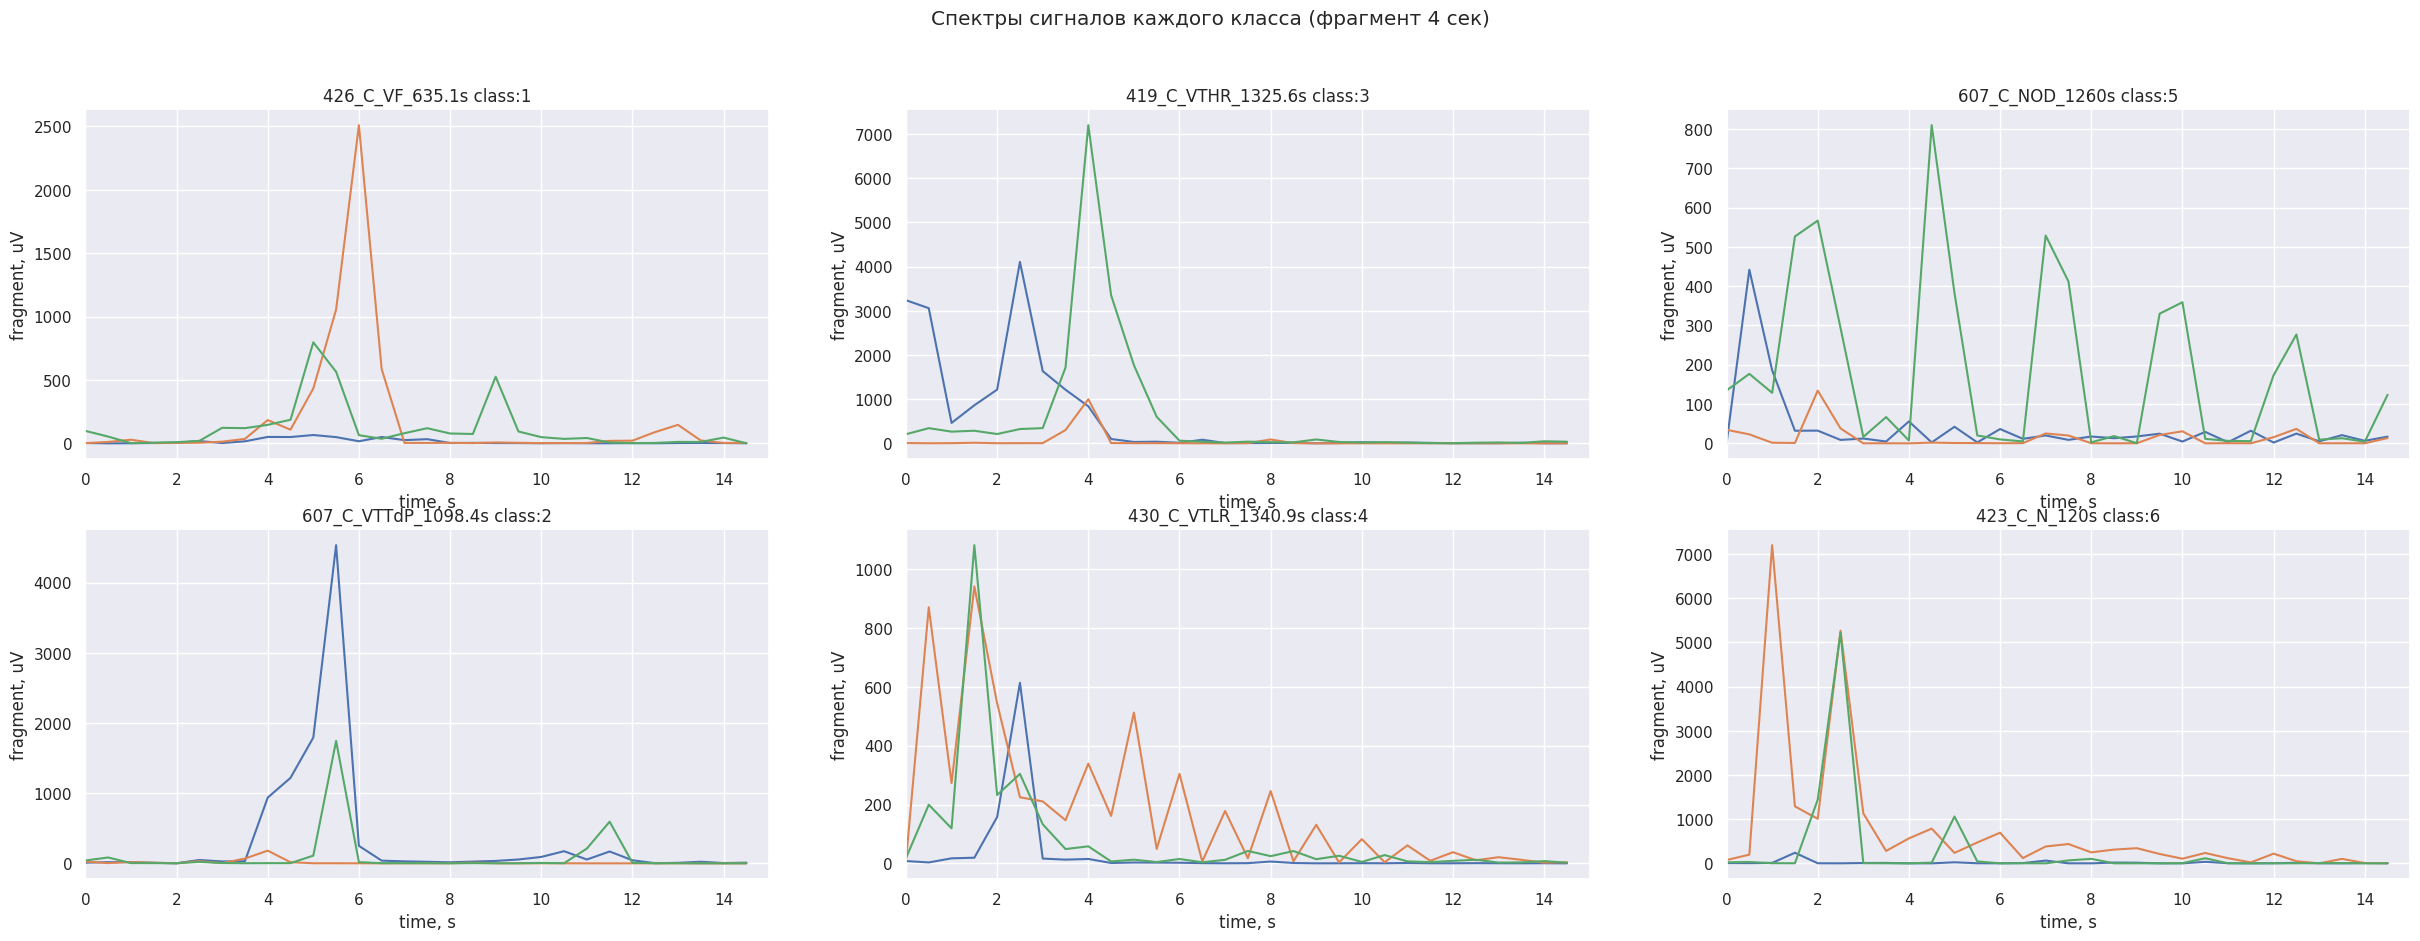

In [ ]:
present_frag(data_4_15_train.drop(columns = 1),'Спектры сигналов каждого класса (фрагмент 4 сек)', 15)

### Подготовка данных

In [ ]:
features_2_15,target_2_15  = data_prepare(data_2_15_train)
features_4_15,target_4_15  = data_prepare(data_4_15_train)

features_2_15_test,target_2_15_test  = data_prepare(data_2_15_test)
features_4_15_test,target_4_15_test  = data_prepare(data_4_15_test)

##Обучение моделей

**Линейный дискриминантный анализ (LDA)**

In [ ]:
columns_score = ['model','best_param',  'f1_score', 'f1_score_mean','accuracy', 'recall', 'precision', 'balanced_accuracy', 'roc_auc_score']
score_df = pd.DataFrame( columns = columns_score)

In [ ]:
parameters_LDA = {'solver' : ['svd', 'lsqr', 'eigen']
                  }
LDA, LDA_score = study_model(LinearDiscriminantAnalysis(), parameters_LDA, features_2_15, target_2_15)


In [ ]:
score_df = pd.concat([score_df, pd.DataFrame([LDA_score], columns = columns_score)],ignore_index=True)
score_df

,model,best_param,f1_score,f1_score_mean,accuracy,recall,precision,balanced_accuracy,roc_auc_score
0,LinearDiscriminantAnalysis(),{'solver': 'svd'},0.92345,0.92345,0.91358,0.931023,0.917197,0.909708,0.960998


Для 4 секунд

In [ ]:
score_df_4 = pd.DataFrame( columns = columns_score)


In [ ]:
parameters_LDA = {'solver' : ['svd', 'lsqr', 'eigen']
                  }
LDA, LDA_score = study_model(LinearDiscriminantAnalysis(), parameters_LDA, features_4_15, target_4_15)
score_df_4 = pd.concat([score_df_4, pd.DataFrame([LDA_score], columns = columns_score)],ignore_index=True)
score_df_4

,model,best_param,f1_score,f1_score_mean,accuracy,recall,precision,balanced_accuracy,roc_auc_score
0,LinearDiscriminantAnalysis(),{'solver': 'svd'},0.91445,0.91445,0.901943,0.928955,0.901046,0.896997,0.966115


**Метод ближайших соседей (kNN)**

In [ ]:
parameters_knn = {'n_neighbors' : [2,5,10,15],
                  'weights' : ['uniform', 'distance'],
                  'metric' : ['minkowski', 'euclidean', 'manhattan']}
knn, knn_score = study_model(KNeighborsClassifier(), parameters_knn, features_2_15, target_2_15)

In [ ]:
score_df = pd.concat([score_df, pd.DataFrame([knn_score], columns = columns_score)],ignore_index=True)
score_df

,model,best_param,f1_score,f1_score_mean,accuracy,recall,precision,balanced_accuracy,roc_auc_score
0,LinearDiscriminantAnalysis(),{'solver': 'svd'},0.923450,0.923450,0.913580,0.931023,0.917197,0.909708,0.960998
1,"KNeighborsClassifier(metric='manhattan', n_nei...","{'metric': 'manhattan', 'n_neighbors': 10, 'we...",0.946922,0.946922,0.941975,0.927079,0.968707,0.943416,0.981073


Для 4 секунд

In [ ]:
parameters_knn = {'n_neighbors' : [2,5,10,15],
                  'weights' : ['uniform', 'distance'],
                  'metric' : ['minkowski', 'euclidean', 'manhattan']
                   }
knn, knn_score = study_model(KNeighborsClassifier(), parameters_knn, features_4_15, target_4_15)
score_df_4 = pd.concat([score_df_4, pd.DataFrame([knn_score], columns = columns_score)],ignore_index=True)
score_df_4

,model,best_param,f1_score,f1_score_mean,accuracy,recall,precision,balanced_accuracy,roc_auc_score
0,LinearDiscriminantAnalysis(),{'solver': 'svd'},0.914450,0.914450,0.901943,0.928955,0.901046,0.896997,0.966115
1,"KNeighborsClassifier(metric='manhattan', n_nei...","{'metric': 'manhattan', 'n_neighbors': 2, 'wei...",0.941647,0.941647,0.934624,0.937342,0.947278,0.934911,0.959573


**Метод опорных векторов (SVM)**

In [ ]:
parameters_svm = {'kernel' : ['linear', 'poly', 'rbf'],
                  'degree': [2,3],
                   'random_state' : [1234],
                  'class_weight' :['balanced', None],
                  'probability': [True]}
cvm, cvm_score = study_model(SVC(), parameters_svm, features_2_15, target_2_15)

In [ ]:
score_df = pd.concat([score_df, pd.DataFrame([cvm_score], columns = columns_score)],ignore_index=True)
score_df

,model,best_param,f1_score,f1_score_mean,accuracy,recall,precision,balanced_accuracy,roc_auc_score
0,LinearDiscriminantAnalysis(),{'solver': 'svd'},0.923450,0.923450,0.913580,0.931023,0.917197,0.909708,0.960998
1,"KNeighborsClassifier(metric='manhattan', n_nei...","{'metric': 'manhattan', 'n_neighbors': 10, 'we...",0.946922,0.946922,0.941975,0.927079,0.968707,0.943416,0.981073
2,"SVC(degree=2, probability=True, random_state=1...","{'class_weight': None, 'degree': 2, 'kernel': ...",0.941626,0.941626,0.935802,0.925273,0.959661,0.936999,0.984239


 Для 4 секунд

In [ ]:
parameters_svm = {'kernel' : ['linear', 'poly', 'rbf'],
                  'degree': [2,3],
                   'random_state' : [1234],
                  'class_weight' :['balanced', None],
                  'probability': [True]}
cvm, cvm_score = study_model(SVC(), parameters_svm, features_4_15, target_4_15)
score_df_4 = pd.concat([score_df_4, pd.DataFrame([cvm_score], columns = columns_score)],ignore_index=True)
score_df_4

,model,best_param,f1_score,f1_score_mean,accuracy,recall,precision,balanced_accuracy,roc_auc_score
0,LinearDiscriminantAnalysis(),{'solver': 'svd'},0.914450,0.914450,0.901943,0.928955,0.901046,0.896997,0.966115
1,"KNeighborsClassifier(metric='manhattan', n_nei...","{'metric': 'manhattan', 'n_neighbors': 2, 'wei...",0.941647,0.941647,0.934624,0.937342,0.947278,0.934911,0.959573
2,"SVC(degree=2, probability=True, random_state=1...","{'class_weight': None, 'degree': 2, 'kernel': ...",0.932602,0.932602,0.924200,0.927505,0.938686,0.924690,0.976184


## Вывод 1 задача

In [ ]:
score_df

,model,best_param,f1_score,f1_score_mean,accuracy,recall,precision,balanced_accuracy,roc_auc_score
0,LinearDiscriminantAnalysis(),{'solver': 'svd'},0.923450,0.923450,0.913580,0.931023,0.917197,0.909708,0.960998
1,"KNeighborsClassifier(metric='manhattan', n_nei...","{'metric': 'manhattan', 'n_neighbors': 10, 'we...",0.946922,0.946922,0.941975,0.927079,0.968707,0.943416,0.981073
2,"SVC(degree=2, probability=True, random_state=1...","{'class_weight': None, 'degree': 2, 'kernel': ...",0.941626,0.941626,0.935802,0.925273,0.959661,0.936999,0.984239


In [ ]:
score_df.loc[1, 'best_param']

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}

In [ ]:
score_df.to_csv('score_2.csv')

In [ ]:
score_df_4

,model,best_param,f1_score,f1_score_mean,accuracy,recall,precision,balanced_accuracy,roc_auc_score
0,LinearDiscriminantAnalysis(),{'solver': 'svd'},0.914450,0.914450,0.901943,0.928955,0.901046,0.896997,0.966115
1,"KNeighborsClassifier(metric='manhattan', n_nei...","{'metric': 'manhattan', 'n_neighbors': 2, 'wei...",0.941647,0.941647,0.934624,0.937342,0.947278,0.934911,0.959573
2,"SVC(degree=2, probability=True, random_state=1...","{'class_weight': None, 'degree': 2, 'kernel': ...",0.932602,0.932602,0.924200,0.927505,0.938686,0.924690,0.976184


In [ ]:
score_df_4.loc[1, 'best_param']

{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}

In [ ]:
score_df_4.to_csv('score_4.csv')

##Тестирование моделей

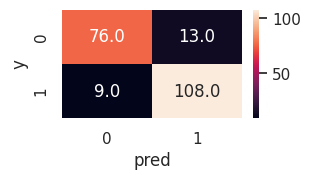

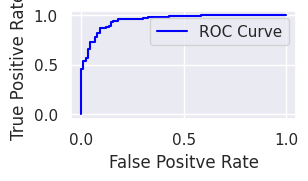

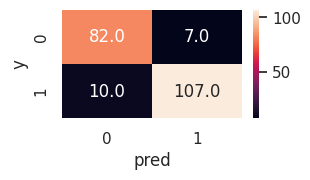

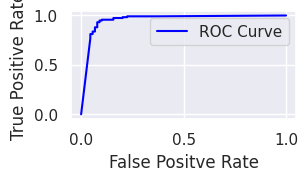

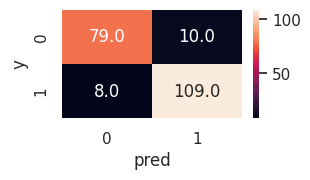

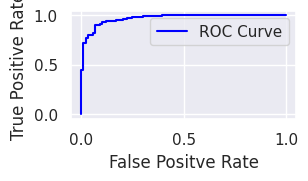

,model,f1,accuracy,recall,precision,balanced_acc
0,LinearDiscriminantAnalysis(),0.907563,0.893204,0.923077,0.892562,0.888505
1,"KNeighborsClassifier(metric='manhattan', n_nei...",0.926407,0.917476,0.914530,0.938596,0.917939
2,"SVC(degree=2, probability=True, random_state=1...",0.923729,0.912621,0.931624,0.915966,0.909632


In [ ]:
score_df_test = test_result(score_df.iloc[:,0], features_2_15_test, target_2_15_test)
score_df_test

In [ ]:
score_df_test.to_csv('score_df_2_test.csv')

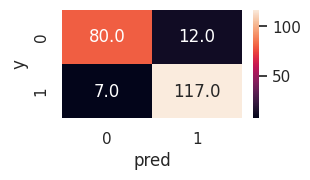

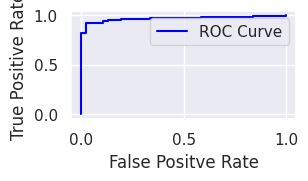

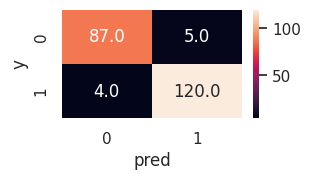

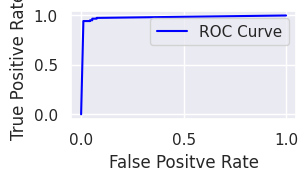

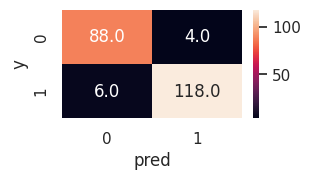

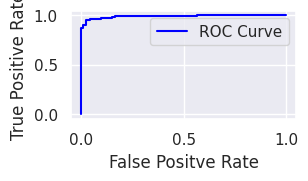

,model,f1,accuracy,recall,precision,balanced_acc
0,LinearDiscriminantAnalysis(),0.924901,0.912037,0.943548,0.906977,0.906557
1,"KNeighborsClassifier(metric='manhattan', n_nei...",0.963855,0.958333,0.967742,0.960000,0.956697
2,"SVC(degree=2, probability=True, random_state=1...",0.959350,0.953704,0.951613,0.967213,0.954067


In [ ]:
score_df_4_test = test_result(score_df_4.iloc[:,0], features_4_15_test, target_4_15_test)
score_df_4_test

In [ ]:
score_df_4_test.to_csv('score_df_4_test.csv')